In [2]:
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

In [3]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

# Image Load/Preprocessing 

In [6]:
# https://zhuanlan.zhihu.com/p/30315331
path = "../img"
prd_num = len(listdir(path))

transform = transforms.Compose([transforms.Resize((224,224)), ## CenterCrop
                                transforms.ToTensor()])
                                #transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = ImageFolder(root = path,
                         transform = transform)

data_loader = torch.utils.data.DataLoader(data_image,
                                         batch_size=3,
                                         shuffle=True,
                                         num_workers=0)

tensor(3) tensor(1) tensor(5)


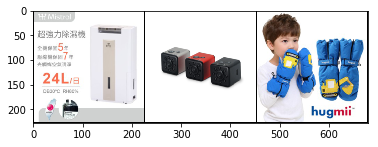

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(3)))

In [9]:
#data_image.imgs
data_image.class_to_idx

{'0': 0,
 'camera': 1,
 'chair': 2,
 'dehumidifier': 3,
 'filter': 4,
 'golve': 5,
 'piano': 6,
 'shoe': 7}

In [10]:
def get_image(imagefolder, label):
    num = 0
    folder_idx = imagefolder.class_to_idx[label]
    for i in range(len(imagefolder)):
        if imagefolder[i][1] == folder_idx and num > 0:
            x_test = torch.cat((x_test, imagefolder[i][0].unsqueeze(0)), dim=0)
        elif imagefolder[i][1] == folder_idx:
            x_test = imagefolder[i][0].unsqueeze(0)
            num += 1
    return x_test

torch.Size([6, 3, 224, 224])


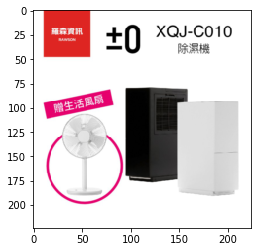

In [104]:
x_test = get_image(data_image, 'dehumidifier')
print(x_test.shape)
imshow(x_test[0])

In [105]:
# https://blog.csdn.net/whut_ldz/article/details/78874977
# https://blog.csdn.net/whut_ldz/article/details/78845947

class Net(nn.Module):
    def __init__(self , model):
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        
    def forward(self, x):
        x = self.resnet_layer(x)
        return x
      
# ResNet18        
resnet18 = models.resnet18(pretrained=True)  ##download pretrained model
pretrained_dict_18 = resnet18.state_dict()
model_18 = Net(resnet18)
model_dict_18 = model_18.state_dict()

# 1. filter out unnecessary keys
pretrained_dict_18 = {k: v for k, v in pretrained_dict_18.items() if k in model_dict_18}
# 2. overwrite entries in the existing state dict
model_dict_18.update(pretrained_dict_18) 
# 3. load the new state dict
model_18.load_state_dict(model_dict_18)

In [106]:
resnet50 = models.resnet50(pretrained=True)
pretrained_dict_50 = resnet50.state_dict()
model_50 = Net(resnet50)
model_dict_50 = model_50.state_dict()

pretrained_dict_50 = {k: v for k, v in pretrained_dict_50.items() if k in model_dict_50}
model_dict_50.update(pretrained_dict_50) 
model_50.load_state_dict(model_dict_50)

In [107]:
def test(model_1):
    model_1.eval()
    with torch.no_grad():
        output = model_1(x_test)
    return output

In [108]:
y_test_18 = test(model_18)
y_test_50 = test(model_50)

In [109]:
y_test.shape

torch.Size([6, 512, 7, 7])

In [110]:
# calculate similarity matrix
feature_18 = y_test_18.reshape(len(y_test_18.numpy()), -1).numpy()
feature_50 = y_test_50.reshape(len(y_test_50.numpy()), -1).numpy()
sim_18 = cosine_similarity(feature_18)
sim_50 = cosine_similarity(feature_50)

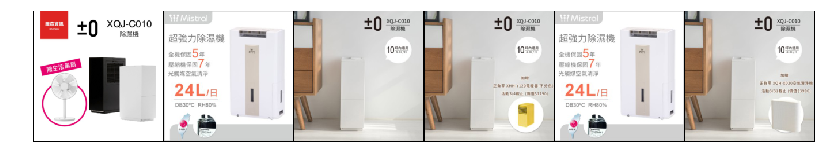

ResNet18
[1.         0.57519567 0.44203815 0.49655983 0.5762777  0.4988672 ]
[0.57519567 1.         0.37795526 0.45353487 0.9996837  0.44241548]
[0.44203815 0.37795523 0.99999994 0.805991   0.37819472 0.82073987]
[0.49655983 0.4535349  0.805991   0.99999994 0.4535265  0.9351635 ]
[0.57627773 0.9996837  0.37819475 0.45352653 1.0000001  0.44275612]
[0.4988672  0.44241545 0.82073987 0.9351635  0.44275612 1.        ]
--------------------------------------------------------------------------------
ResNet50
[1.0000001  0.5096238  0.37783977 0.40941656 0.5095299  0.44578126]
[0.5096238  1.         0.36364496 0.3758685  0.9990896  0.3825286 ]
[0.37783977 0.36364496 1.         0.863164   0.36371195 0.82211137]
[0.40941656 0.37586847 0.86316407 1.0000001  0.3754754  0.92588973]
[0.5095298  0.9990896  0.36371198 0.3754754  1.0000001  0.38212758]
[0.4457813  0.3825286  0.82211137 0.9258897  0.38212758 1.0000001 ]


In [111]:
# show image
img = torchvision.utils.make_grid(x_test).numpy()
fig = plt.figure(figsize=(14, 14))
plt.imshow(np.transpose(img,(1,2,0)))
plt.axis('off')
plt.show()
# show similarity result
num = len(x_test)
print('ResNet18')
for i in range(num):
    print(sim_18[i])
print('-'*80)
print('ResNet50')
for i in range(num):
    print(sim_50[i])

torch.Size([7, 7])


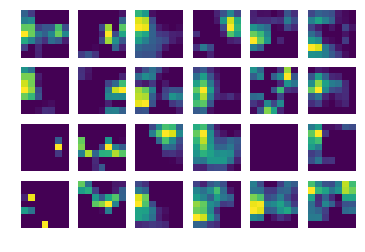

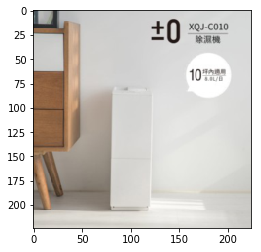

In [112]:
img_num = 2
print(y_test[1][1].shape)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(y_test_18[img_num][i], interpolation = 'none')
    plt.axis('off')
    #plt.title("Class {}".format(class_names[y_train[i]]))
#plt.tight_layout()
plt.show()
imshow(x_test[img_num])

In [ ]:
img_num = 2
print(y_test[1][1].shape)
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(y_test_18[img_num][i], interpolation = 'none')
    plt.axis('off')
    #plt.title("Class {}".format(class_names[y_train[i]]))
#plt.tight_layout()
plt.show()
imshow(x_test[img_num])